In [15]:
import alborex_functions
import alborexdata
import netCDF4
import glob
import os
import json
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap 
import numpy as np
import datetime
from importlib import reload

In [16]:
reload(alborexdata)

<module 'alborexdata' from '/home/ctroupin/Publis/201703_AlborexData/python/alborexdata.py'>

In [3]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# Configuration

In [4]:
with open('alborexconfig.json') as json_data_file:
    config = json.load(json_data_file)

Create a logger

In [5]:
logger = alborexdata.configure_logging("./logs/alborexFigure4.log")

Domain

In [6]:
coordinates = config["domain"]["coordinates1"]
coordinates2 = config["domain"]["coordinates2"]

Create a list of netCDF files containing SST

In [7]:
figdir = config["figdir"]
sstdir = config["datadirs"]["sst"]
coastfile = config["datafiles"]["coast"]

# Data reading and plotting

Make figure directory if necessary.

In [9]:
if os.path.isdir(figdir):
    logger.debug("Figure directory {0} already exists".format(figdir))
else:
    os.makedirs(figdir)
    logger.debug("Creating figure directory {0}".format(figdir))

2018-07-30 10:25:18,887 - alborex_logger - DEBUG - Figure directory /home/ctroupin/Publis/201703_AlborexData/figures already exists


## Load data
### Coastline

In [10]:
loncoast, latcoast = alborexdata.read_lonlat_coast(coastfile)

## SST

In [11]:
sstfile = os.path.join(sstdir, "A2014150020500.L2_LAC_SST4.nc")
sst = alborexdata.SST()
sst.read_from_oceancolorL2(sstfile)
# sst.apply_qc()

## Front position

In [12]:
frontcoords = "../data/front_coordinates.dat"
f = alborexdata.Front()
f.get_from_file(frontcoords)
f.smooth()

Create the projection

In [13]:
m = Basemap(projection='merc', llcrnrlon=coordinates2[0], llcrnrlat=coordinates2[2],
            urcrnrlon=coordinates2[1], urcrnrlat=coordinates2[3],
            lat_ts=0.5 * (coordinates2[2] + coordinates2[3]), resolution='h')

## Make the plot

2018-07-30 10:26:54,140 - alborex_logger - INFO - Making figure fig06a


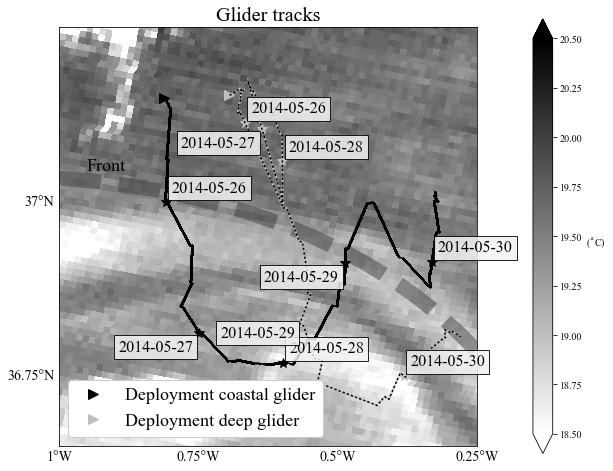

In [14]:
figname = "fig06"
fignamesst = "fig06_sst"
figtitle = "Glider tracks"
logger.info("Making figure {0}".format(figname))

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
m.ax = ax

# Add the coastline
for i in range(0, len(loncoast)):
    m.plot(np.array(loncoast[i]), np.array(latcoast[i]), 
           color='k', linewidth=.5, latlon=True)

# Grid
alborexdata.add_map_grid(m, coordinates, dlon=.25, dlat=.25,
                         fontname='Times New Roman', fontsize=14, 
                         linewidth=0.2, zorder=1, color=".6")
# Front position
m.plot(f.lon, f.lat, "--", color=".25", linewidth=15, latlon=True, alpha=.5)
xf, yf = m(-0.95, 37.05)
plt.text(xf, yf, "Front", fontsize=18, ha='left', va="center")

colorlist = ["k", ".75"]

for ii, datafiles in enumerate(config["datafiles"]["gliders"]):
    
    # Read data from file
    glider = alborexdata.Glider()
    glider.get_from_netcdf(datafiles)
        
    # Remove masked values
    glider.remove_masked_coords()
    
    # Get indices for the different days
    day_indices, date_list = glider.get_day_indices(ndays=1)
    
 
    # Add first point
    if ii==0:
        deploymenttext = "Coastal glider deployment"
        glider.point_plot(m, marker='o', color=colorlist[ii],
                      linestyle='-', ms=.1, zorder=3) 
    else:
        deploymenttext = "Deep glider deployment"
        glider.point_plot(m, color=colorlist[ii], linewidth=2,
                      linestyle='--', ms=.1, zorder=3) 
        glider.point_plot(m, color="k",
                      linestyle=':', ms=.1, zorder=3) 
        
    glider.add_initial_position(m, marker='>', markersize=10, 
                                color=colorlist[ii], label=deploymenttext)
    
    xp, yp = m(glider.lon[day_indices[:-1]], glider.lat[day_indices[:-1]])
    
    cc = 0
    for xx, yy, tt in zip(xp, yp, date_list[:-1]):
        if np.mod(cc, 2) == 0:
            haparam = "left"
            vaparam = "bottom"
        else:
            haparam = "right"
            vaparam = "top"
            
        plt.text(xx + 1000 * (-1)** cc, yy + 1000 * (-1)** cc, tt.strftime("%Y-%m-%d"), 
                 bbox=dict(facecolor='.95', alpha=0.85),
                 va=vaparam, ha=haparam, fontsize=16)
        cc += 1
    
    m.plot(glider.lon[day_indices[:-1]], glider.lat[day_indices[:-1]], marker='*',
           linewidth=0, color=colorlist[ii], ms=10, latlon=True)

    plt.legend(loc=3, fontsize=18, framealpha=1)
    
plt.title(figtitle, fontsize=20)

plt.savefig(os.path.join(figdir, figname), dpi=300, bbox_inches='tight')

# Add SST as background
pcm = m.pcolormesh(sst.lon, sst.lat, sst.field, latlon=True, 
                   vmin=18.5, vmax=20.5, cmap=plt.cm.gray_r)
cb = plt.colorbar(pcm, shrink=.8, extend="both", pad=.1)
cb.set_label("($^{\circ}$C)", rotation=0, ha="left")
plt.savefig(os.path.join(figdir, fignamesst), dpi=300, bbox_inches='tight')
plt.show()
plt.close()